# Final Project Model: Aerobic and Anaerobic Digestion

### Austin Booth, Dominick Cammuso, and Connor Wozniak

This model will predict concentrations of biomass, glucose, ethanol, and glycerol over time given an input value of dissolved oxygen (DO). Constants and initial conditions are the same as, or adapted from, the dynamic model of Hjersted et al. Digestion is assumed to be occurring in a reactor containing Saccharomyces cerevisiae.

# 1. Summary of Variables

### X = biomass concentration
Measured process variable (component of y vector). Units: g/L. X0 = 0.1 g/L.

### G = glucose concentration
State variable. Input in biomass production. Units: g/L. G0 = 50 g/L. Can be treated as an MV if we want to add glucose to the reactor.

### E = ethanol concentration
Product of the reactor. Assume this is also a measured process variable (component of y vector). Units: g/L. E0 = 0 g/L.

### Y = glycerol concentration
Product of the reactor. Assume this is an unmeasured byproduct. State variable. Units: g/L. Assume Y0 = 0 g/L.

### DO = dissolved oxygen concentration
Manipulated variable. Input in biomass production. Not directly used in the state space model, but relevant to the linear optimization problem. It is assumed that DO can be regulated by a feedback controller (Hjersted et al.).

DO = O/Osat, where Osat = saturation conc. = 0.30 mmol/L. DO units: fraction saturation (unitless).





# 2. Initial Calculations
Preliminary parameters needed to create the digester model will be calculated here. These parameters will primarily be fluxes, expressed in units of mmol/g/h.

## 2.1. Calculating Glucose and Oxygen Fluxes
The following calculations will require the glucose and oxygen fluxes, or uptake rates, to be known. The allowed glucose flux can be calculated directly as

$$v_g = v_{gm}\frac{G}{K_g + G}\frac{1}{1 + (E / K_{ie})}$$

The allowed oxygen flux can be found by
$$v_o = v_{om}\frac{DO}{DO + (K_o / O_{sat})}$$

Functions for calculating glucose and oxygen fluxes are given below.

In [8]:
# define known constants
v_gm = 20    # mmol/g/h
K_g = 0.5    # g/L
v_om = 8     # mmol/g/h
K_o = 0.003  # mmol/L
O_sat = 0.30 # mmol/L
K_ie = 10    # g/L
X0 = 0.1     # g/L
G0 = 50      # g/L
E0 = 0       # g/L
Y0 = 0       # g/L

# define function to calculate glucose flux, v_g
def glucose(G, E):
    v_g = v_gm * (G / (K_g + G)) * (1 / (1 + E/K_ie))
    return v_g

# define function to calculate oxygen flux, v_o
def oxygen(DO):
    v_o = v_om * DO / (DO + K_o/O_sat)
    return v_o

# test functions
v_g = glucose(G0,E0)
print('Allowed glucose flux at initial conditions is',round(v_g,3),'mmol/g/h')

v_o = oxygen(1.0)
print('Allowed oxygen flux at maximum DO (aerobic) is',round(v_o,3),'mmol/g/h')
v_o2 = oxygen(0)
print('Allowed oxygen flux in anaerobic conditions is',round(v_o2,3),'mmol/g/h')

Allowed glucose flux at initial conditions is 19.802 mmol/g/h
Allowed oxygen flux at maximum DO (aerobic) is 7.921 mmol/g/h
Allowed oxygen flux in anaerobic conditions is 0.0 mmol/g/h


## 2.2. Simplified Linear Program
In Hjersted et al., the cellular growth rate, or total allowed flux of biomass, is found by a linear program:

\begin{align}
\max {\mu} & = \sum_{j} w_j v_j
\end{align}

where v for each component is its flux and w is its weight, subject to the constraints

$$Av = 0$$ and $$v_{min} < v < v_{max}$$

where A is a stoichiometric matrix of a metabolic network, v is a vector of fluxes, and v_min and v_max are vectors of upper and lower flux bounds.

To simplify, we will assume that glucose and oxygen are the only relevant inputs to biomass production, and for further simplification, we will assume that their weights are both 1. Thus, in this highly simplified model, the cellular growth rate is equal to the allowed uptake rate of oxygen plus the allowed uptake rate of glucose.

In [9]:
# calculate cellular growth rate
mu = v_g + v_o

print('Total allowed cellular growth rate is',round(mu,3),'mmol/g/h')

Total allowed cellular growth rate is 27.723 mmol/g/h


## 2.3. Mass Balance

The remaining fluxes were found in Hjersted et al. by using the matrix and vector constraints mentioned above. However, the stoichiometric matrices of the metabolic networks are extremely involved and not given in any detail in this paper, and they contain many times more variables than we are concerned with here. The maximum and minimum flux constraints are also not discussed at all in this paper. For this reason, we will solve for the ethanol and glyverol fluxes using a mass and a carbon balance.

According to Lange et al. (https://onlinelibrary.wiley.com/doi/abs/10.1002/bit.10054), the molecular weight of S. cerevisiae biomass is 26.4 g/mol. The MW of glycerol is 92.094 g/mol, the MW of ethanol is 46.07 g/mol, the MW of glucose is 180.16 g/mol, and the MW of oxygen is 32.00 g/mol.

Fluxes are expressed relative to total biomass concentration (X), and each species' rate of change is given by its respective flux times X. The units of vX in each case are 
$$\frac{dA}{dt} = v_a*X = \frac{mmol}{g*h}*\frac{g}{L} = \frac{mmol}{L*h} = \frac{mM}{h}$$

To find each species' rate of change in terms of its original mass-based units, we can take

$$\frac{dA_{true}}{dt} = v_a*X*MW_a*\frac{1}{1000} = \frac{mmol}{g*h}*\frac{g}{L}*\frac{g}{mol}*\frac{mol}{mmol}
= \frac{g}{L*h}$$

If we take out the common factor of X/1000 for each component and consider inputs and outputs, the mass balance can be simplified to:

$$v_g MW_g + v_o MW_o - \mu MW_x - v_e MW_e - v_y MW_y = 0$$

We now need additional constraints to find both unknowns, v_e and v_y. As in Hjersted et al., our objective will be to maximize ethanol production, so we will set the objective to maximize ethanol flux with the arbitrary constraint that it must not exceed the total growth rate.

In [81]:
import numpy as np
import cvxpy as cp

# enter molecular weights
MW_x = 26.4    # g/mol
MW_y = 92.094  # g/mol
MW_e = 46.07   # g/mol
MW_g = 180.16  # g/mol
MW_o = 32.00   # g/mol

# make relevant elements negative in data structure
data = {
    'X': {'MW': -MW_x, 'H': -0.596},
    'Y': {'MW': -MW_y, 'H': -3},
    'E': {'MW': -MW_e, 'H': -1},
    'G': {'MW': MW_g, 'H': 6},
    'O': {'MW': MW_o, 'H': 2},
}

# create function that will solve mass balance to maximize ethanol flux
def solve_EG(mu, v_g, v_o, data):
    # create set of components
    components = set(data.keys())
    
    # create variables
    v = {c: cp.Variable(nonneg=True, name=c) for c in components}
    
    # create objective function
    objective = cp.Maximize(v['E'])
    
    # create list of constraints
    constraints = [

        v['X'] == mu,
        v['O'] == v_o,
        v['G'] == v_g,
        v['E'] <= mu,

        0 == sum(v[c]*data[c]['MW'] for c in components),
    ]
    
    # create and solve problem
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    # return results
    v_e = problem.value
    optimal_blend = {c: v[c].value for c in components}
    v_e = optimal_blend['E']
    v_y = optimal_blend['Y']
    return v_e, v_y, optimal_blend


# print results for DO = 1 and DO = 0
print('Aerobic digestion with DO = 1 and initial conditions:')
v_e, v_y, optimal_blend = solve_EG(mu,v_g,v_o,data)
print(v_e)
print(v_y)
for c in (optimal_blend.keys()):
    print(f"{c} flux: {optimal_blend[c]:5.2f} mmol/g/h")
    
print()
print('Anaerobic digestion with DO = 0 and initial conditions:')
v_e, v_y, optimal_blend = solve_EG((v_g + v_o2),v_g,v_o2,data)
for c in (optimal_blend.keys()):
    print(f"{c} flux: {optimal_blend[c]:5.2f} mmol/g/h")

Aerobic digestion with DO = 1 and initial conditions:
27.722772276906497
19.674688818967653
G flux: 19.80 mmol/g/h
O flux:  7.92 mmol/g/h
E flux: 27.72 mmol/g/h
Y flux: 19.67 mmol/g/h
X flux: 27.72 mmol/g/h

Anaerobic digestion with DO = 0 and initial conditions:
G flux: 19.80 mmol/g/h
O flux:  0.00 mmol/g/h
E flux: 19.80 mmol/g/h
Y flux: 23.16 mmol/g/h
X flux: 19.80 mmol/g/h


# 3. Nonlinear Model

Now that we have a way to get fluxes for each component, we can use the series of differential equations from Hjersted et al. to develop a time-dependent model of the reactor. The paper's equations are multiplied by molecular weight and divided by 1000 to get d[A]/dt in units of g/h instead of mM/h.

For future use, we will add R, the input rate of glucose, in g/h.

\begin{align}
\frac{dX}{dt} & = \mu X * MW_x / 1000\\
\frac{dG}{dt} & = -v_g X * MW_g / 1000 + R_{input}(t)\\
\frac{dE}{dt} & = v_e X * MW_e / 1000\\
\frac{dY}{dt} & = v_y X * MW_y / 1000\\
\end{align}

where mu, v_g, v_e, and v_y are all dependent on G, E, and DO. This model will be derived below similarly to in Notebook 2.4.

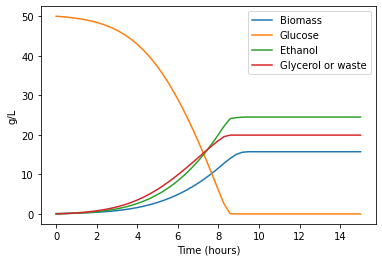

In [100]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# create function to determine manipulated value DO
def DO_MV(t):
    DO = 1.0
    return DO

# create function to set glucose addition rate R
def Radd(t):
    R = 0
    return R

# create time vector
t_expt = np.linspace(0,15,50)

def model_second_order(plot=False):    

    # model solution
    def deriv(t, y):
        # unpack variables
        X, G, E, Y = y
        
        # calculate parameters
        DO = DO_MV(t)
        v_o = oxygen(DO)
        
        # prevent model from failing by stopping growth once glucose is depleted
        if G - Radd(t) > 0:
            v_g = glucose(G, E)
            mu = v_o + v_g
        else:
            v_g = 0
            mu = 0
            v_o = 0
        
        v_e, v_y, optimal_blend = solve_EG(mu, v_g, v_o, data)
        
        
        dX = mu * X * MW_x / 1000
        dG = -v_g * X * MW_g / 1000 + Radd(t)
        dE = v_e * X * MW_e / 1000
        dY = v_y * X * MW_y / 1000

        return [dX, dG, dE, dY]

    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], [X0, G0, E0, Y0], t_eval=t_expt) 
    
    # create vectors with predictions
    Xpred = soln.y[0]
    Gpred = soln.y[1]
    Epred = soln.y[2]
    Ypred = soln.y[3]


    # plot solution
    if plot:
        plt.plot(t_expt, Xpred, t_expt, Gpred, t_expt, Epred, t_expt, Ypred)
        plt.xlabel('Time (hours)')
        plt.ylabel('g/L')
        plt.legend(['Biomass','Glucose','Ethanol','Glycerol or waste'])
    
model_second_order(plot=True)

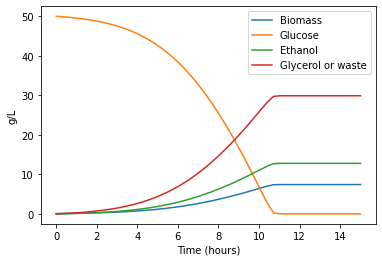

In [101]:
# with DO = 0
def DO_MV(t):
    DO = 0
    return DO
model_second_order(plot=True)

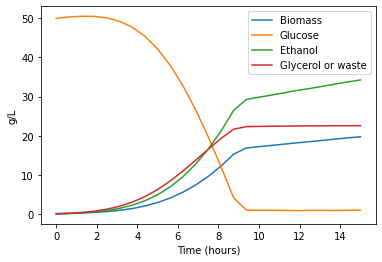

In [107]:
# create time vector
t_expt = np.linspace(0,15,25)

# with DO = 1 and a glucose addition rate of 1 g/h
def DO_MV(t):
    DO = 1.0
    return DO

def Radd(t):
    R = 1
    return R

model_second_order(plot=True)

# 4. Linear State-Space Model

A linear state-space model can be constructed without the complications of nonlinearly concentration-dependent expressions for fluxes.

For aerobic digestion, assuming DO >> 0.01, we can approximate $$v_o = v_{om}$$
For anaerobic digestion, $$v_o = 0$$

Notably, this result is suitable for relay control; i.e., on-off switching between aerobic and anaerobic conditions. If we assume that DO control is relay (1 or 0), we can say that $$v_o = v_{om}*DO$$

This result could be used for more complex control as well; the model would just be less realistic.

Also, if we assume G >> Kg and E << K_ie for the entire reaction, we can approximate 
$$v_g = v_{gm}\frac{G}{G}\frac{1}{1} = v_{gm}$$

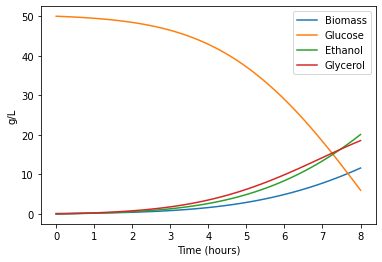

In [76]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# create function to determine manipulated value DO
def DO_MV(t):
    DO = 1.0
    return DO

# create time vector
t_expt = np.linspace(0,8,50)

def model_second_order(plot=False):    

    # model solution
    def deriv(t, y):
        # unpack variables
        X, G, E, Y = y
        
        # calculate parameters
        DO = DO_MV(t)
        v_o = oxygen(DO)
        v_g = glucose(G, E)
        mu = v_o + v_g
        v_e, v_y, optimal_blend = solve_EG(mu, v_g, v_o, data)
        
        
        dX = mu * X * MW_x / 1000
        dG = -v_g * X * MW_g / 1000
        dE = v_e * X * MW_e / 1000
        dY = v_y * X * MW_y / 1000

        return [dX, dG, dE, dY]

    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], [X0, G0, E0, Y0], t_eval=t_expt) 
    
    # create vectors with predictions
    Xpred = soln.y[0]
    Gpred = soln.y[1]
    Epred = soln.y[2]
    Ypred = soln.y[3]


    # plot solution
    if plot:
        plt.plot(t_expt, Xpred, t_expt, Gpred, t_expt, Epred, t_expt, Ypred)
        plt.xlabel('Time (hours)')
        plt.ylabel('g/L')
        plt.legend(['Biomass','Glucose','Ethanol','Glycerol'])
    
model_second_order(plot=True)